In [20]:
install.packages("cowplot")
install.packages("themis")
install.packages("kknn") 

Updating HTML index of packages in '.Library'

Making 'packages.html' ...
 done

Updating HTML index of packages in '.Library'

Making 'packages.html' ...
 done

Updating HTML index of packages in '.Library'

Making 'packages.html' ...
 done



In [21]:
library(tidyverse)
library(repr)
library(tidymodels)
library(cowplot)
library(themis)
library(kknn)
options(repr.matrix.max.rows = 9)

In [3]:
download.file("https://archive.ics.uci.edu/static/public/186/wine+quality.zip", "wine.zip")

In [4]:
unzip("wine.zip", "winequality-white.csv")

In [7]:
white_wine_data <- read_csv2("winequality-white.csv", show_col_types = FALSE) |>
    mutate_if(is.character, as.numeric) |>
    mutate(quality = as.factor(quality)) |>
    select(quality, `volatile acidity`, `chlorides`, `density`, `pH`, `sulphates` )
    
white_wine_data 

ℹ Using "','" as decimal and "'.'" as grouping mark. Use `read_delim()` for more control.



quality,volatile acidity,chlorides,density,pH,sulphates
<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
6,0.27,0.045,1.0010,3,0.45
6,0.30,0.049,0.9940,33,0.49
6,0.28,0.050,0.9951,326,0.44
6,0.23,0.058,0.9956,319,0.40
6,0.23,0.058,0.9956,319,0.40
⋮,⋮,⋮,⋮,⋮,⋮
5,0.32,0.047,0.99490,315,0.46
6,0.24,0.041,0.99254,299,0.46
7,0.29,0.022,0.98869,334,0.38


In [29]:
wine_recipe_balance <- recipe(quality ~ ., data = wine_data)|>
    step_upsample(quality, over_ratio = 1, skip = FALSE) |>
    prep()
wine_recipe_balance

Recipe

Inputs:

      role #variables
   outcome          1
 predictor          5

Training data contained 3673 data points and no missing data.

Operations:

Up-sampling based on quality [trained]

In [33]:
balanced_wine <- bake(wine_recipe_balance, white_wine_data)
balanced_wine |> group_by(quality) |> summarise(n = n())

quality,n
<fct>,<int>
3,1652
4,1652
5,1652
6,2198
7,1652
8,1652
9,1652


In [105]:
set.seed(2024)
wine_data_split <- white_wine_data |>
    initial_split(prop = 0.75, strata = quality)
wine_data_split_2 <- balanced_wine |>
    initial_split(prop = 0.75, strata = quality)

wine_data_train <- training(wine_data_split)
wine_data_train_2 <- training(wine_data_split_2)
wine_data_test <- testing(wine_data_split)
wine_vfold <- vfold_cv(wine_data_train, v = 5, strata = quality)

wine_data_train_2

volatile acidity,chlorides,density,pH,sulphates,quality
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>
0.32,0.053,0.9958,314,0.50,3
0.26,0.074,0.9980,302,0.50,3
0.32,0.038,0.9937,324,0.40,3
0.64,0.244,0.9983,287,0.74,3
0.39,0.022,0.9915,331,0.37,3
⋮,⋮,⋮,⋮,⋮,⋮
0.26,0.032,0.9903,337,0.42,9
0.27,0.035,0.9970,32,0.46,9
0.26,0.032,0.9903,337,0.42,9


In [101]:
knn_tune <- nearest_neighbor(weight_func = "rectangular", neighbors = tune()) |>
    set_engine("kknn") |>
    set_mode("classification")

In [55]:
wine_recipe <- recipe(quality ~ ., data = wine_data_train_2 )|>
    step_center(all_predictors()) |>
    step_scale(all_predictors())

In [109]:
k_vals <- tibble(neighbors = seq(from = 1, to = 100))
wine_tune <- workflow() |>
    add_recipe(wine_recipe) |>
    add_model(knn_tune) |>
    tune_grid(resamples = wine_vfold, grid = k_vals) |>
    collect_metrics()
wine_tune
    

! Fold3: internal:
  There were 100 warnings in `dplyr::summarise()`.
  The first warning was:
  ℹ In argument: `.estimate = metric_fn(...)`.
  ℹ In group 1: `neighbors = 1`.
  Caused by warning:
  ! No observations were detected in `truth` for level(s): '9'
  Computation will proceed by ignoring those levels.
  ℹ Run `dplyr::last_dplyr_warnings()` to see the 99 ...

! Fold4: internal:
  There were 100 warnings in `dplyr::summarise()`.
  The first warning was:
  ℹ In argument: `.estimate = metric_fn(...)`.
  ℹ In group 1: `neighbors = 1`.
  Caused by warning:
  ! No observations were detected in `truth` for level(s): '9'
  Computation will proceed by ignoring those levels.
  ℹ Run `dplyr::last_dplyr_warnings()` to see the 99 ...

! Fold5: internal:
  There were 100 warnings in `dplyr::summarise()`.
  The first warning was:
  ℹ In argument: `.estimate = metric_fn(...)`.
  ℹ In group 1: `neighbors = 1`.
  Caused by warning:
  ! No observations were detected in `truth` for level(s): '9'
 

neighbors,.metric,.estimator,mean,n,std_err,.config
<int>,<chr>,<chr>,<dbl>,<int>,<dbl>,<chr>
1,accuracy,multiclass,0.5622133,5,0.008817042,Preprocessor1_Model001
1,roc_auc,hand_till,0.6274235,5,0.010053946,Preprocessor1_Model001
2,accuracy,multiclass,0.5622133,5,0.008817042,Preprocessor1_Model002
2,roc_auc,hand_till,0.6332694,5,0.011964233,Preprocessor1_Model002
3,accuracy,multiclass,0.5104944,5,0.009154409,Preprocessor1_Model003
⋮,⋮,⋮,⋮,⋮,⋮,⋮
99,accuracy,multiclass,0.4987870,5,0.006966005,Preprocessor1_Model099
99,roc_auc,hand_till,0.6591608,5,0.022285236,Preprocessor1_Model099
100,accuracy,multiclass,0.4993293,5,0.006924478,Preprocessor1_Model100


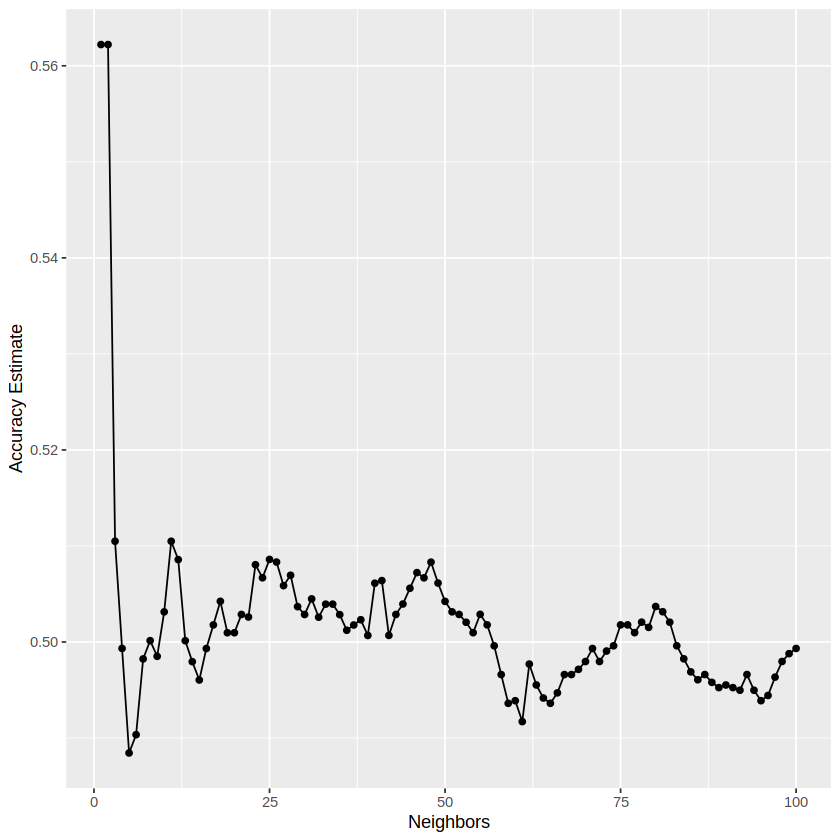

In [110]:
accuracy_versus_k <- wine_tune |>
    filter(.metric == "accuracy") |>
    ggplot(aes(x = neighbors, y = mean))+
       geom_point() +
       geom_line() +
       labs(x = "Neighbors", y = "Accuracy Estimate") 

accuracy_versus_k

In [95]:
knn_tune <- nearest_neighbor(weight_func = "rectangular", neighbors = 2) |>
    set_engine("kknn") |>
    set_mode("classification")

In [96]:
wine_fit <- workflow() |>
    add_recipe(wine_recipe) |>
    add_model(knn_tune) |>
    fit(wine_data_train_2)

In [97]:
wine_fit

══ Workflow [trained] ══════════════════════════════════════════════════════════
Preprocessor: Recipe
Model: nearest_neighbor()

── Preprocessor ────────────────────────────────────────────────────────────────
2 Recipe Steps

• step_center()
• step_scale()

── Model ───────────────────────────────────────────────────────────────────────

Call:
kknn::train.kknn(formula = ..y ~ ., data = data, ks = min_rows(2,     data, 5), kernel = ~"rectangular")

Type of response variable: nominal
Minimal misclassification: 0.1223299
Best kernel: rectangular
Best k: 2

In [98]:
wine_predictions <- wine_fit |>
predict(wine_data_test) |>
bind_cols(wine_data_test)

mnist_metrics <- wine_predictions |> 
    metrics(truth = quality, estimate = .pred_class) |>
    filter(.metric == "accuracy")
mnist_metrics

wine_predictions |> 
    conf_mat(truth = quality, estimate = .pred_class)

.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
accuracy,multiclass,0.8261224


          Truth
Prediction   3   4   5   6   7   8   9
         3   5   0   1   1   0   0   0
         4   0  39   8  11   0   0   0
         5   0   0 291  61   9   0   0
         6   0   0  39 433  15   0   0
         7   0   0  15  41 198   0   0
         8   0   0   3   7   2  43   0
         9   0   0   0   0   0   0   3